In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### 0. Simulate phone dataset

Text(0, 0.5, 'SEK/month')

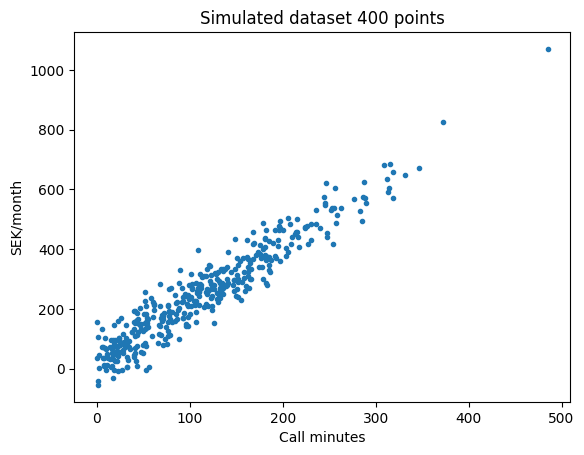

In [123]:
# a) simulate data and plot

np.random.seed(42)
samples = 400

X = abs(np.random.normal(loc=100, scale=100, size=samples))
epsilon = np.random.normal(loc=0, scale=50, size=samples)

y = 25 + 2 * X + epsilon

plt.plot(X, y, ".")
plt.title("Simulated dataset 400 points")
plt.xlabel("Call minutes")
plt.ylabel("SEK/month")


[Text(0.5, 0, 'Call minutes'),
 Text(0, 0.5, 'SEK/month'),
 Text(0.5, 1.0, 'Simulated dataseet 400 poits with boundaries')]

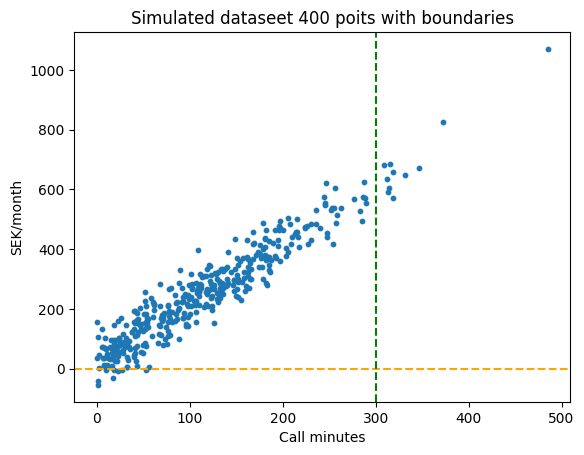

In [124]:
# a) plot simulated data with boundaries

fig, ax = plt.figure(), plt.axes()
ax.scatter(X, y, s=10)
ax.axhline(y=0, linestyle="--", color = "orange")
ax.axvline(x=300, color="green", linestyle="--")
ax.set(xlabel="Call minutes", ylabel="SEK/month", title="Simulated dataseet 400 poits with boundaries")

In [125]:
# b) remove outliers
#????????? varför finns y<0 kvar i y_cleaned??????????????
#????????? varför är shape (400,) och inte (400,1)

# create touple of indexes for outliers where call minutes > 300, use to remove values from X and corresponding from y
index_X_outliers = np.where(X > 300)
X_cleaned = np.delete(X, index_X_outliers)
y_cleaned = np.delete(y, index_X_outliers)

# create touple of indexes for outliers where cost < 0, use to remove values from X and corresponding from y
index_y_outliers = np.where(y < 0)
X_cleaned = np.delete(X_cleaned, index_y_outliers)
y_cleaned = np.delete(y_cleaned, index_y_outliers)

X.shape, X_cleaned.shape, y.shape, y_cleaned.shape

((400,), (381,), (400,), (381,))

Text(0, 0.5, 'SEK/month')

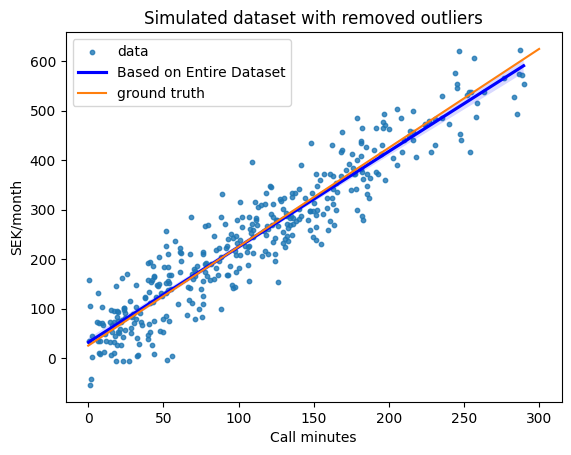

In [126]:
# b) plot ground truth and data without outliers

x = np.linspace(0, 300)
y_hat = 25 + 2 * x

sns.regplot(
    x=X_cleaned,
    y=y_cleaned,
    label="data",
    line_kws={"color": "blue", "label": "Based on Entire Dataset"},
    scatter_kws={"s": 10}, 
) 
sns.lineplot(x=x, y=y_hat, label="ground truth")
plt.title("Simulated dataset with removed outliers")
plt.xlabel("Call minutes")
plt.ylabel("SEK/month")


In [131]:
# b) save values as dataframe
# ????????? Hur gör jag för att rader skall bli kolumner? .T eller .reshape funkar inte... inte helelr len(array)??????????
df = pd.DataFrame(data=(X_cleaned, y_cleaned))
df.head()

,0,1,2,3,4,5,6,7,8,9,...,371,372,373,374,375,376,377,378,379,380
0,149.671415,86.173570,164.768854,252.302986,76.584663,76.586304,257.921282,176.743473,53.052561,154.256004,...,10.158533,149.191917,32.023321,283.145877,217.944012,53.082435,71.313453,235.387237,88.546015,223.781631
1,244.621448,167.378389,354.799893,531.955001,155.666051,209.315105,487.461542,371.367972,137.119904,359.233950,...,66.797977,333.768219,102.625583,527.454324,406.835197,183.822512,165.649148,529.849510,203.507950,474.051069


In [134]:
# Lösning från Andreas

df = pd.DataFrame()
df["call_minutes"] = X_cleaned
df["cost"] = y_cleaned
df.head()

,call_minutes,cost
0,149.671415,244.621448
1,86.173570,167.378389
2,164.768854,354.799893
3,252.302986,531.955001
4,76.584663,155.666051
